In [1]:
import keras
from keras.layers import Activation, Dense, Input, Flatten, Dropout, Lambda, Softmax
from keras.models import Model
from keras import regularizers
from keras import backend as K
import tensorflow as tf

import numpy as np
from scipy import sparse
import pandas as pd
import os
import gc
import bottleneck as bn

from sklearn.utils import shuffle
from keras.callbacks import Callback, TensorBoard
import time

Using TensorFlow backend.


In [2]:
DATA_DIR = 'mpd_proc/data_small_2'

unique_sid = list()
with open(os.path.join(DATA_DIR, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

69675

In [4]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
n_users = df['uid'].max() + 1

rows, cols = df['uid'], df['sid']
train = sparse.csr_matrix((np.ones_like(rows),
                         (rows, cols)), dtype='float64',
                         shape=(n_users, n_items))

In [5]:
sparsity = 1. * df.shape[0] / (n_users * n_items)

print("%d playlist inclusion events from %d playlist and %d tracks (sparsity: %.3f%%)" % 
      (df.shape[0], n_users, n_items, sparsity * 100))

37116328 playlist inclusion events from 373740 playlist and 69675 tracks (sparsity: 0.143%)


In [6]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [7]:
valid_train, valid_test = load_tr_te_data(os.path.join(DATA_DIR, 'validation_tr.csv'),
                                           os.path.join(DATA_DIR, 'validation_te.csv'))

In [8]:
idcg = lambda x, k: np.sum(1/np.log2(np.arange(2, min(k, x)+2)))
vidcg = np.vectorize(idcg)
    
def ndcg_recall_on_batch(preds, holdouts, k=100):
    N, M = preds.shape
    total_items = holdouts.getnnz(axis=1)
    
    top_inds = bn.argpartition(-preds, k, axis=1)[:,:k]
    top_items = preds[np.arange(N)[:, np.newaxis],top_inds]
    ranked_inds = np.argsort(-top_items, axis=1)[:,:k]
    ranked_items = top_inds[np.arange(N)[:,np.newaxis],ranked_inds]

    matches = holdouts[np.expand_dims(np.arange(N), 1),ranked_items]
    dcg = np.sum(matches/np.log2(np.arange(k)+2), axis=1)
    idcg = vidcg(total_items, k)
    ndcg = dcg/idcg
    
    recalls = np.sum(matches, axis=1)/np.minimum(k, total_items)
    
    return ndcg, recalls

In [9]:
def neg_multi_ll(yTrue,yPred):
    return -K.mean(K.sum(yTrue * K.log(yPred)))
    
class MultiDAEKeras(object):

    def __init__(self):
        
        K.clear_session()
        
        
    def setup(self):
        
        h1 = 200

        enc_inputs = Input(shape=(n_items,), name='enc_input')
        inputs_normed = Lambda(lambda  x: tf.nn.l2_normalize(x, dim=1))(enc_inputs)
        x = Dropout(0.5)(inputs_normed)

        latent1_enc = Dense(h1, activation='tanh', name='latent1_enc', kernel_regularizer=regularizers.l2(0.01))(x)
        
        self.encoder = Model(enc_inputs, latent1_enc, name='encoder')
        
        dec_inputs = Input(shape=(h1,), name='dec_inputs')

        logits = Dense(n_items, name='logits_dec', kernel_regularizer=regularizers.l2(0.01))(dec_inputs)
        probs = Softmax(name='probs_dec')(logits) 
        
        self.decoder = Model(dec_inputs, probs, name='decoder')

        self.dae = Model(inputs=enc_inputs, outputs=self.decoder(self.encoder(enc_inputs)), name='denoising_autoencoder')
        
        return self.dae 


In [10]:
def data_generator(data, batch_size):
    N = data.shape[0]
    while True:
        roworder = np.random.permutation(N)
        for start in range(0, N, batch_size):
            end = min(N, start+batch_size)
            batch = data[roworder[start:end]]
            batch = batch.toarray().astype('float32')
            yield (batch, batch)
            

In [11]:
class RecMetrics(Callback):
    
    def __init__(self, val_train_data, val_test_data, model_dir, k = 100):
        self.val_train_data = val_train_data
        self.val_test_data = val_test_data
        self.k = k
        self.best_ndcg = 0
        self.model_dir = model_dir
        
        return
    
    def on_train_begin(self, logs={}):
        self.ndcg_hist = []
        self.recall_hist = []
        return
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):
        N = self.val_train_data.shape[0]
        ndcg_list = []
        recall_list = []
        
        for start in range(0, N, 500):
            end = min(N, start+500)
            X = self.val_train_data[start:end]
            X = X.toarray().astype('float32')
            preds = np.asarray(self.model.predict(X))
            preds[X.nonzero()] = -np.inf
            ndcg_batch, recall_batch = ndcg_recall_on_batch(preds, self.val_test_data[start:end], self.k)
            ndcg_list.append(ndcg_batch)
            recall_list.append(recall_batch)
            
        ndcg = np.mean(ndcg_list)
        recall = np.mean(recall_list)
        
        print ("NDCG: {}".format(ndcg))
        print ("Recall: {}".format(recall))
        self.ndcg_hist.append(ndcg)
        self.recall_hist.append(recall)
        
        if ndcg > self.best_ndcg: 
            self.model.save(os.path.join(self.model_dir, 'model.h5'))
            self.best_ndcg = ndcg
            
        return
 
    def on_batch_begin(self, batch, logs={}):
        return
 
    def on_batch_end(self, batch, logs={}):
        return

In [12]:

logdir = './logs/data_small/multidae-200'
modeldir = './models/data_small/multidae-200'

rec_metrics = RecMetrics(valid_train, valid_test, model_dir = modeldir, k=100)

tb = TensorBoard(log_dir=logdir)

In [16]:
gc.collect()

3780

In [17]:
dae = MultiDAEKeras()
model = dae.setup()
model.compile(loss=neg_multi_ll, optimizer='adam') ## adam with default lr=1e-3

In [18]:
batch_size = 500

model.fit_generator(data_generator(train, batch_size),
                 verbose=1, 
                 epochs=15,
                 steps_per_epoch = train.shape[0]//batch_size,
                 callbacks=[rec_metrics, tb])

Epoch 1/15
747/747 [==============================] - 188s 251ms/step - loss: 412681.8652
NDCG: 0.29255816455989503
Recall: 0.40307823997591324
Epoch 2/15
747/747 [==============================] - 182s 244ms/step - loss: 373923.4830
NDCG: 0.32853023114555974
Recall: 0.44261870974511736
Epoch 3/15
747/747 [==============================] - 182s 243ms/step - loss: 366889.5353
NDCG: 0.3457002624647591
Recall: 0.4615737724554046
Epoch 4/15
747/747 [==============================] - 185s 247ms/step - loss: 362699.9330
NDCG: 0.3566647047552956
Recall: 0.47359314935239105
Epoch 5/15
747/747 [==============================] - 185s 248ms/step - loss: 359624.7168
NDCG: 0.36302863588037687
Recall: 0.4812133828390846
Epoch 6/15
747/747 [==============================] - 179s 240ms/step - loss: 357246.8353
NDCG: 0.36826633649612417
Recall: 0.4874339627713047
Epoch 7/15
747/747 [==============================] - 180s 240ms/step - loss: 355310.6306
NDCG: 0.37086083834996264
Recall: 0.490440145566055

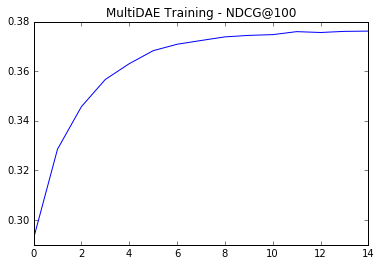

In [28]:

plt.plot(rec_metrics.ndcg_hist)
plt.title('MultiDAE Training - NDCG@100')